In [1]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, BertModel, BertForSequenceClassification, BertTokenizer
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Concatenate, GlobalAveragePooling1D
from keras import backend as K
import torch
from torchsummary import summary
import tensorflow as tf
import datasets
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from time import time
import copy
import gc

# Training of the ITE model

## Loading the embeddings as the inputs and the ITE as the target

In [2]:
#Sentiment and general embeddings of the factuals
sent_fact_outs = np.load('outs/counterfactuals/sent_fact_outs.npy')
gen_fact_outs = np.load('outs/counterfactuals/gen_fact_outs.npy')
conc_fact = np.concatenate([sent_fact_outs,gen_fact_outs],axis=1)

#Copying the factuals in order to have one for each counterfactual.
n_cf = 5
fact_n_cf = [] 
for i in range(len(conc_fact)):
    for j in range(n_cf):
        fact_n_cf.append(conc_fact[i])
fact_n_cf = np.array(fact_n_cf)

In [3]:
#Adding the counterfactuals
sent_cf_off_outs = np.load('outs/counterfactuals/sent_cf_off_outs.npy')
gen_cf_off_outs = np.load('outs/counterfactuals/gen_cf_off_outs.npy')
conc_cf = np.concatenate([sent_cf_off_outs,gen_cf_off_outs],axis=1)

fact_n_cf = np.concatenate([fact_n_cf,conc_cf],axis=0)

In [4]:
ITE_peace = np.load('outs/counterfactuals/ITE_peace.npy')

#Duplicate the ITEs to match the concatenation of factuals_x_5 and counterfactuals
ITE_peace = np.concatenate([ITE_peace,ITE_peace],axis=0)

## Training the model to evaluate the regression

In [5]:
def mse(y_true, y_pred):
        return np.mean(np.square(y_true - y_pred))

In [6]:
n_runs = 10

In [7]:
fact_train,fact_test,ITE_train,ITE_test = train_test_split(fact_n_cf,ITE_peace,test_size=0.3,random_state=42)

In [8]:
best_val_loss = np.inf
best_ITE_model = None
for i in range(n_runs):
    ITE_model = Sequential([
              Flatten(),
              Dense(128, activation='relu'),
              Dense(64, activation='relu'),
              Dense(1, activation='tanh')
          ])
    ITE_model.compile(optimizer='adam', loss="mean_squared_error")
    history = ITE_model.fit(fact_train,ITE_train,epochs=20,batch_size=32,validation_split=0.1)
    
    # Get the last validation loss
    last_val_loss = history.history['val_loss'][-1]
    # Compare with the best validation loss
    if last_val_loss < best_val_loss:
        best_val_loss = last_val_loss
        best_ITE_model = ITE_model

Epoch 1/20
602/602 [==============================] - 2s 2ms/step - loss: 0.0948 - val_loss: 0.0771
Epoch 2/20
602/602 [==============================] - 1s 2ms/step - loss: 0.0763 - val_loss: 0.0791
Epoch 3/20
602/602 [==============================] - 1s 1ms/step - loss: 0.0697 - val_loss: 0.0700
Epoch 4/20
602/602 [==============================] - 1s 1ms/step - loss: 0.0650 - val_loss: 0.0655
Epoch 5/20
602/602 [==============================] - 1s 2ms/step - loss: 0.0603 - val_loss: 0.0665
Epoch 6/20
602/602 [==============================] - 1s 2ms/step - loss: 0.0564 - val_loss: 0.0615
Epoch 7/20
602/602 [==============================] - 1s 2ms/step - loss: 0.0529 - val_loss: 0.0632
Epoch 8/20
602/602 [==============================] - 1s 2ms/step - loss: 0.0506 - val_loss: 0.0590
Epoch 9/20
602/602 [==============================] - 1s 2ms/step - loss: 0.0488 - val_loss: 0.0600
Epoch 10/20
602/602 [==============================] - 1s 2ms/step - loss: 0.0461 - val_loss: 0.0576

In [9]:
ITE_pred_train = np.squeeze(best_ITE_model.predict(fact_train))
ITE_pred_test = np.squeeze(best_ITE_model.predict(fact_test))

287/287 [==============================] - 0s 842us/step


In [10]:
print("MSE train:",mse(ITE_train,ITE_pred_train))
print("MSE test:",mse(ITE_test,ITE_pred_test))

MSE train: 0.032715544
MSE test: 0.05406826


In [11]:
print("ATE pred. train:",np.mean(ITE_pred_train))
print("ATE pred. test:",np.mean(ITE_pred_test))

ATE pred. train: 0.29615417
ATE pred. test: 0.30305767


## Training the model with all the data (training and test sets)

In [12]:
best_val_loss = np.inf
best_ITE_model = None
for i in range(n_runs):
    ITE_model = Sequential([
              Flatten(),
              Dense(128, activation='relu'),
              Dense(64, activation='relu'),
              Dense(1, activation='tanh')
          ])
    ITE_model.compile(optimizer='adam', loss="mean_squared_error")
    history = ITE_model.fit(fact_n_cf,ITE_peace,epochs=25,batch_size=32,validation_split=0.1)
    
    # Get the last validation loss
    last_val_loss = history.history['val_loss'][-1]
    # Compare with the best validation loss
    if last_val_loss < best_val_loss:
        best_val_loss = last_val_loss
        best_ITE_model = ITE_model

Epoch 1/25
860/860 [==============================] - 2s 2ms/step - loss: 0.0952 - val_loss: 0.0890
Epoch 2/25
860/860 [==============================] - 1s 2ms/step - loss: 0.0737 - val_loss: 0.0827
Epoch 3/25
860/860 [==============================] - 1s 2ms/step - loss: 0.0668 - val_loss: 0.0780
Epoch 4/25
860/860 [==============================] - 1s 2ms/step - loss: 0.0619 - val_loss: 0.0759
Epoch 5/25
860/860 [==============================] - 2s 2ms/step - loss: 0.0578 - val_loss: 0.0771
Epoch 6/25
860/860 [==============================] - 1s 2ms/step - loss: 0.0538 - val_loss: 0.0769
Epoch 7/25
860/860 [==============================] - 1s 1ms/step - loss: 0.0507 - val_loss: 0.0820
Epoch 8/25
860/860 [==============================] - 1s 1ms/step - loss: 0.0484 - val_loss: 0.0799
Epoch 9/25
860/860 [==============================] - 1s 1ms/step - loss: 0.0461 - val_loss: 0.0830
Epoch 10/25
860/860 [==============================] - 1s 1ms/step - loss: 0.0439 - val_loss: 0.0781

In [13]:
#Prediction of the factuals
ITE_pred_fact = np.squeeze(best_ITE_model.predict(conc_fact))

96/96 [==============================] - 0s 1ms/step


In [14]:
best_ITE_model.save('models/ITE_model/models/ITE_model')

INFO:tensorflow:Assets written to: models/ITE_model/models/ITE_model\assets


## ATE of the factuals

In [15]:
print("ATE:",np.mean(ITE_pred_fact))

ATE: 0.29615065


<Axes: >

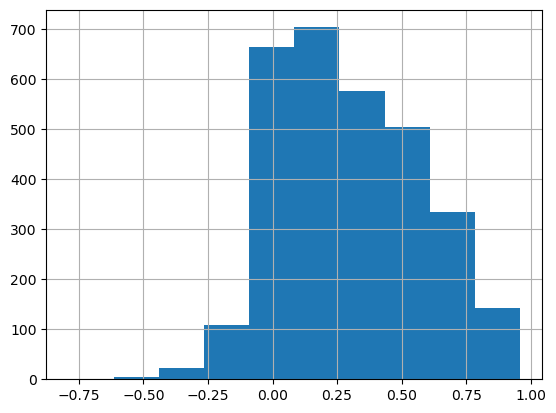

In [16]:
pd.Series(ITE_pred_fact).hist()

# Training a PEACE model with all our data

## Load Embeddings

In [17]:
frenk_sent_train = np.load('outs/frenk/sent_train_outs.npy')
frenk_gen_train = np.load('outs/frenk/gen_train_outs.npy')

In [18]:
try_sent_train = np.load('outs/try/sent_train_outs.npy')
try_gen_train = np.load('outs/try/gen_train_outs.npy')

In [19]:
fact_sent = np.load('outs/counterfactuals/sent_fact_outs.npy')
fact_gen = np.load('outs/counterfactuals/gen_fact_outs.npy')

In [20]:
sent_train = np.concatenate([frenk_sent_train,try_sent_train,fact_sent],axis=0)
gen_train = np.concatenate([frenk_gen_train,try_gen_train,fact_gen],axis=0)

In [21]:
conc_train = np.concatenate([sent_train,gen_train],axis=1)

## Load Labels

In [22]:
#FRENK dataset
df_train = pd.read_csv('data/frenk_train.tsv',sep='\t')
frenk_label_train = df_train["label"].to_numpy()

In [23]:
#Twi-Red-You dataset
df_train = pd.read_csv('data/try_train.tsv',sep='\t')
try_label_train = df_train['label'].to_numpy()

In [24]:
#Factuals
df_factuals = pd.read_csv('data/factuals.tsv',sep='\t')
labels_factuals = df_factuals["label"].to_numpy()

In [25]:
label_train = np.concatenate([frenk_label_train,try_label_train,labels_factuals])

In [26]:
c_weights = compute_class_weight('balanced', classes=np.unique(label_train), y=label_train)
c_weights = {0:c_weights[0], 1:c_weights[1]}

## Training and validation splits

In [27]:
conc_train,conc_val,label_train,label_val = train_test_split(conc_train,label_train,test_size=0.1,random_state=42)

## Training the PEACE model

In [28]:
best_f1_val = 0
best_model = None
for i in range(n_runs):
    hate_model = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    hate_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hate_model.fit(conc_train, label_train, class_weight=c_weights, epochs=10, batch_size=32)
    
    #Selecting the model with best f1 score in the validation set
    f_hate = np.squeeze(hate_model.predict(conc_val))
    preds = (f_hate > 0.5).astype(int)
    f1_val = metrics.f1_score(preds,label_val,zero_division=1)
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_model = hate_model

Epoch 1/10
603/603 [==============================] - 2s 3ms/step - loss: 0.5505 - accuracy: 0.7072
Epoch 2/10
603/603 [==============================] - 2s 3ms/step - loss: 0.5174 - accuracy: 0.7263
Epoch 3/10
603/603 [==============================] - 2s 3ms/step - loss: 0.5028 - accuracy: 0.7370
Epoch 4/10
603/603 [==============================] - 2s 3ms/step - loss: 0.4931 - accuracy: 0.7380
Epoch 5/10
603/603 [==============================] - 2s 3ms/step - loss: 0.4799 - accuracy: 0.7462
Epoch 6/10
603/603 [==============================] - 2s 3ms/step - loss: 0.4675 - accuracy: 0.7549
Epoch 7/10
603/603 [==============================] - 2s 3ms/step - loss: 0.4589 - accuracy: 0.7541
Epoch 8/10
603/603 [==============================] - 2s 4ms/step - loss: 0.4429 - accuracy: 0.7657
Epoch 9/10
603/603 [==============================] - 2s 3ms/step - loss: 0.4313 - accuracy: 0.7726
Epoch 10/10
67/67 [==============================] - 0s 2ms/step
Epoch 1/10
603/603 [===============

In [29]:
best_model.save('models/ITE_model/models/PEACE_model')

INFO:tensorflow:Assets written to: models/ITE_model/models/PEACE_model\assets
